In [1]:
pip install torch torchvision transformers matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [9]:
# import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset

# Define the dataset class
class AlzheimerMRIDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset
data_dir = '/kaggle/input/Alzheimer_MRI_4_classes_dataset'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
image_paths = []
labels = []
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(idx)

# Split the dataset into train (80%), validation (10%), and test (10%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42
)

# Define transformations with data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),     # Randomly rotate images by +/- 10 degrees
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation and testing (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = AlzheimerMRIDataset(train_paths, train_labels, transform=train_transform)
val_dataset = AlzheimerMRIDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = AlzheimerMRIDataset(test_paths, test_labels, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 5120
Validation set size: 640
Test set size: 640


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


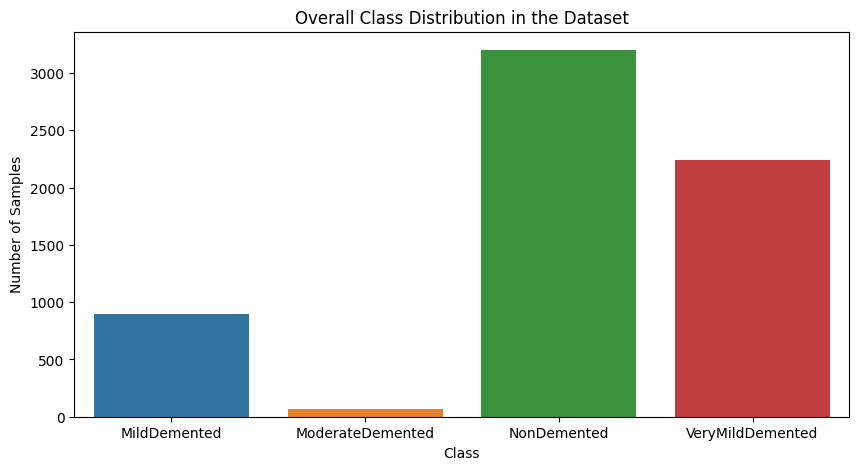

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Combine all labels (train, validation, and test)
all_labels = train_labels + val_labels + test_labels

# Count class distribution for the entire dataset
def count_classes(labels, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    for label in labels:
        class_counts[class_names[label]] += 1
    return class_counts

# Get overall class counts
overall_class_counts = count_classes(all_labels, classes)

# Plot overall class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(overall_class_counts.keys()), y=list(overall_class_counts.values()))
plt.title('Overall Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [4]:
print(set(all_labels))  # Check unique values in all_labels


{0, 1, 2, 3}


In [13]:
# Convert lists to NumPy arrays
image_paths_np = np.array(train_paths + val_paths + test_paths)
labels_np = np.array(train_labels + val_labels + test_labels)

# Apply oversampling to (image paths, labels)
ros = RandomOverSampler(random_state=42)
image_paths_resampled, labels_resampled = ros.fit_resample(image_paths_np.reshape(-1, 1), labels_np)

# Flatten the image paths back
image_paths_resampled = image_paths_resampled.flatten()

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths_resampled, labels_resampled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


New Training Class Distribution: Counter({0: 2583, 1: 2567, 2: 2554, 3: 2536})
New Validation Class Distribution: Counter({3: 346, 1: 325, 2: 317, 0: 292})
New Testing Class Distribution: Counter({2: 329, 0: 325, 3: 318, 1: 308})


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


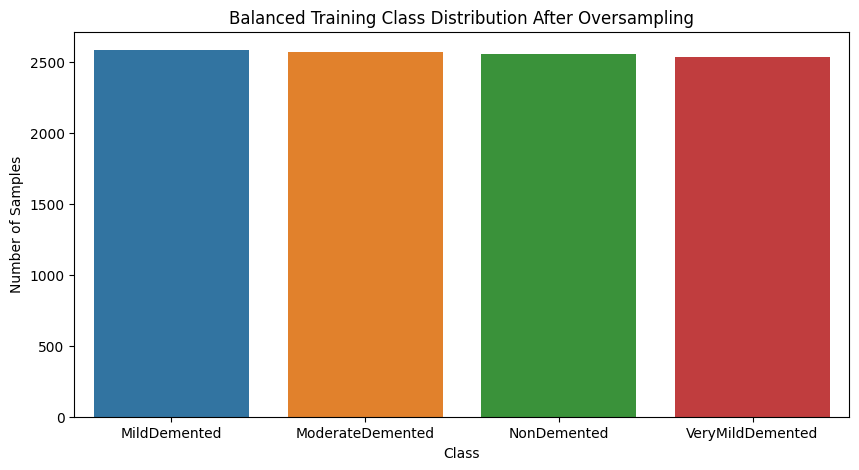

In [14]:

# Step 4: Print new class distributions
print("New Training Class Distribution:", Counter(y_train))
print("New Validation Class Distribution:", Counter(y_val))
print("New Testing Class Distribution:", Counter(y_test))

# Step 5: Plot the new class distribution for training set
plt.figure(figsize=(10, 5))
sns.barplot(x=list(Counter(y_train).keys()), y=list(Counter(y_train).values()))
plt.xticks(ticks=[0, 1, 2, 3], labels=["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"])
plt.title('Balanced Training Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

In [15]:
# Create datasets
train_dataset = AlzheimerMRIDataset(X_train, y_train, transform=train_transform)
val_dataset = AlzheimerMRIDataset(X_val, y_val, transform=val_test_transform)
test_dataset = AlzheimerMRIDataset(X_test, y_test, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Load the pre-trained ViT model and feature extractor
model_name = 'google/vit-base-patch16-224'
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(classes),  # Set the number of output classes
    ignore_mismatched_sizes=True  # Ignore size mismatch in the final layer
)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [17]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Add weight decay

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# Number of epochs
num_epochs = 10

# Training loop with early stopping
best_val_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Print training loss and accuracy for the epoch
    train_accuracy = 100 * train_correct / train_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Print validation accuracy for the epoch
    val_accuracy = 100 * val_correct / val_total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

    # Update learning rate scheduler
    scheduler.step(val_accuracy)

    # Early stopping: Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f'Best model saved with validation accuracy: {best_val_accuracy:.2f}%')

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Test loop (after training is complete)
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Print test accuracy
print(f'Test Accuracy: {100 * test_correct / test_total:.2f}%')

100%|██████████| 320/320 [06:58<00:00,  1.31s/it]


Epoch [1/10], Loss: 0.6911, Training Accuracy: 67.77%
Validation Accuracy: 76.41%
Best model saved with validation accuracy: 76.41%


100%|██████████| 320/320 [06:32<00:00,  1.23s/it]


Epoch [2/10], Loss: 0.3978, Training Accuracy: 82.66%
Validation Accuracy: 89.14%
Best model saved with validation accuracy: 89.14%


100%|██████████| 320/320 [06:31<00:00,  1.22s/it]


Epoch [3/10], Loss: 0.2329, Training Accuracy: 90.45%
Validation Accuracy: 92.42%
Best model saved with validation accuracy: 92.42%


100%|██████████| 320/320 [06:34<00:00,  1.23s/it]


Epoch [4/10], Loss: 0.1707, Training Accuracy: 93.30%
Validation Accuracy: 93.52%
Best model saved with validation accuracy: 93.52%


100%|██████████| 320/320 [06:32<00:00,  1.23s/it]


Epoch [5/10], Loss: 0.0930, Training Accuracy: 96.49%
Validation Accuracy: 97.73%
Best model saved with validation accuracy: 97.73%


100%|██████████| 320/320 [06:33<00:00,  1.23s/it]


Epoch [6/10], Loss: 0.0800, Training Accuracy: 97.15%
Validation Accuracy: 97.66%


100%|██████████| 320/320 [06:35<00:00,  1.23s/it]


Epoch [7/10], Loss: 0.0640, Training Accuracy: 97.64%
Validation Accuracy: 95.55%


100%|██████████| 320/320 [06:36<00:00,  1.24s/it]


Epoch [8/10], Loss: 0.0694, Training Accuracy: 97.56%
Validation Accuracy: 98.44%
Best model saved with validation accuracy: 98.44%


100%|██████████| 320/320 [06:33<00:00,  1.23s/it]


Epoch [9/10], Loss: 0.0353, Training Accuracy: 98.87%
Validation Accuracy: 97.34%


100%|██████████| 320/320 [06:32<00:00,  1.23s/it]


Epoch [10/10], Loss: 0.0468, Training Accuracy: 98.37%
Validation Accuracy: 98.52%
Best model saved with validation accuracy: 98.52%


<ipython-input-17-5fe34c9666a6>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 98.75%


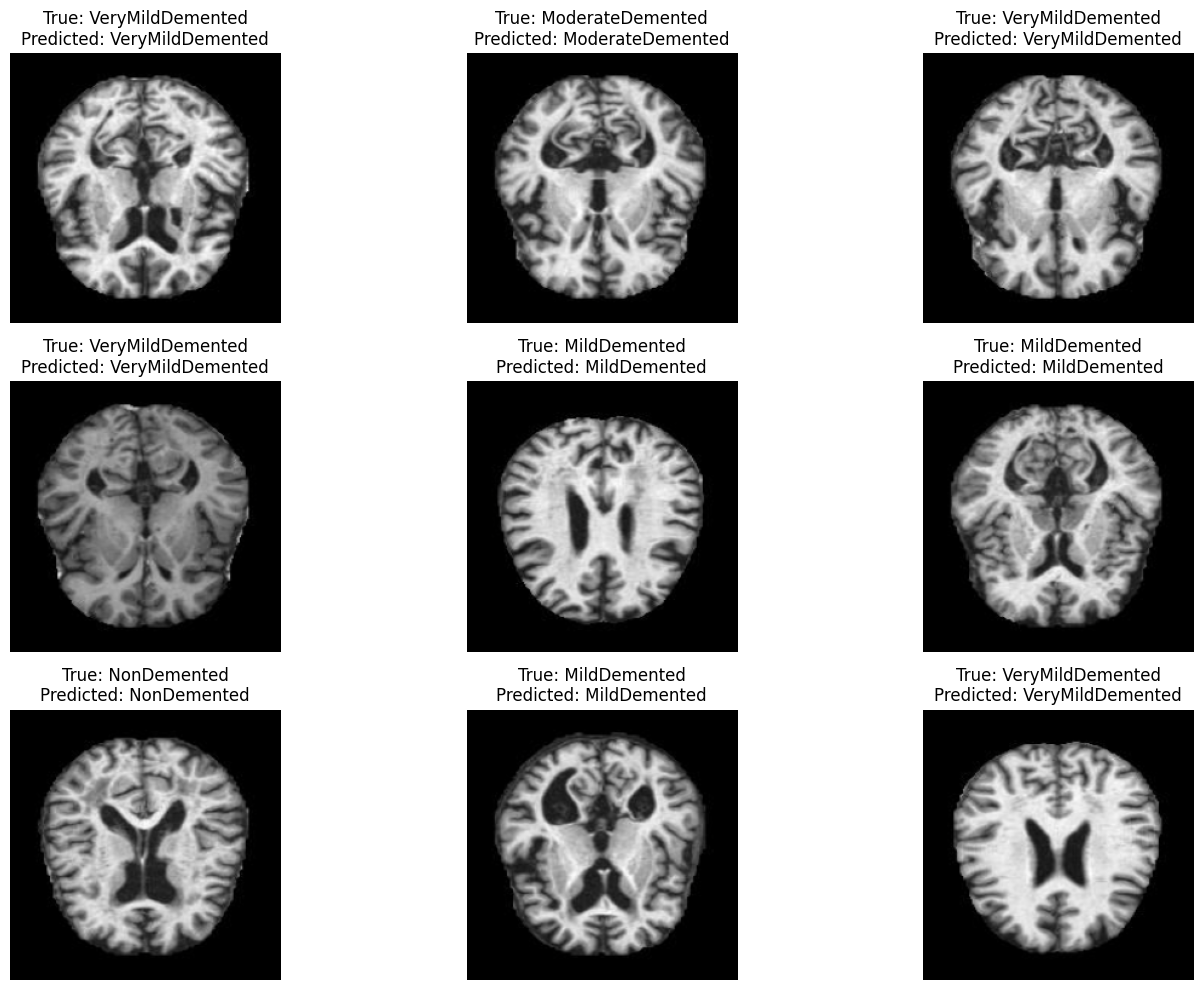

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize the image for visualization
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0)) 
    image = std * image + mean  
    image = np.clip(image, 0, 1) 
    return image

# Get a batch of test data
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images).logits
    _, predicted = torch.max(outputs, 1)

# Convert images and labels to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Plot the images with true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(min(9, len(images))):  
    plt.subplot(3, 3, i + 1)
    image = denormalize(images[i])
    plt.imshow(image)
    plt.title(f'True: {classes[labels[i]]}\nPredicted: {classes[predicted[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

8/9

In [21]:
# Print validation accuracy for the epoch
val_accuracy = 100 * val_correct / val_total
print(f'Validation Accuracy: {val_accuracy:.2f}%')


Validation Accuracy: 98.52%


In [20]:
from sklearn.metrics import classification_report
import numpy as np

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Test loop (after training is complete)
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        # Store predictions and labels for classification report
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print test accuracy
print(f'Test Accuracy: {100 * test_correct / test_total:.2f}%')

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

<ipython-input-20-0b2c62e9e832>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 98.75%

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      1.00       325
ModerateDemented       1.00      1.00      1.00       308
     NonDemented       0.99      0.97      0.98       329
VeryMildDemented       0.97      0.98      0.97       318

        accuracy                           0.99      1280
       macro avg       0.99      0.99      0.99      1280
    weighted avg       0.99      0.99      0.99      1280

